<a href="https://colab.research.google.com/github/Sridipta-Roy/Chest-X-Ray-Image-Classification-using-Deep-Learning/blob/main/Chest_XRay_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
from google.colab import files, drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import IterativeStratification
import warnings
warnings.filterwarnings("ignore")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


In [ ]:
# --- Mount Google Drive---
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


## **Configuration**

In [ ]:
# --- Main Configuration ---
DATA_DIR = "/content/drive/MyDrive/Chest XRay/archive"
PROJECT_DIR = "/content/drive/MyDrive/Chest XRay"
HISTORY_CSV_PATH = os.path.join(PROJECT_DIR, "training_history.csv")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")
!mkdir -p {MODELS_DIR}

METADATA_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
NEW_MEDATA_PATH = os.path.join(DATA_DIR, "metadata_with_full_path.csv") # For dev purpose created a new file with image path added to the CSV

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.4

# For initial testing
USE_SUBSET = True
SUBSET_FRACTION = 0.5 # Use 50% of the data

SEED = 42 # Seed for reproducibility of shuffling.

## **Data Loading**

In [ ]:
# --- Load Metadata ---
#df = pd.read_csv(METADATA_PATH)
df = pd.read_csv(NEW_MEDATA_PATH)

In [ ]:
# def build_image_path_map(image_root):
#     image_path_map = {}
#     for folder in os.listdir(image_root):
#         subfolder = os.path.join(image_root, folder, "images")
#         if not os.path.isdir(subfolder):
#             continue
#         for img_file in os.listdir(subfolder):
#             if img_file.endswith(".png"):
#                 full_path = os.path.join(subfolder, img_file)
#                 image_path_map[img_file] = full_path
#     return image_path_map

# image_path_map = build_image_path_map(PROJECT_DIR)

In [ ]:
# # --- Create Full Image Paths ---
# img_name = df['Image Index']
# df['full_path'] = img_name.map(image_path_map)

In [ ]:
# # Export to csv for easy loading
# df.to_csv(os.path.join(PROJECT_DIR, "metadata_with_full_path.csv"), index=False)

In [ ]:
df = df.dropna(subset=['full_path']) # Drop rows where image file is missing
# Drop column Unnamed:11
df.drop(columns=['Unnamed: 11'], inplace=True)
print(f"Total images found: {len(df)}")

Total images found: 112118


In [ ]:
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/content/drive/MyDrive/Chest XRay/archive/imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/content/drive/MyDrive/Chest XRay/archive/imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...


## **Pre-processing**

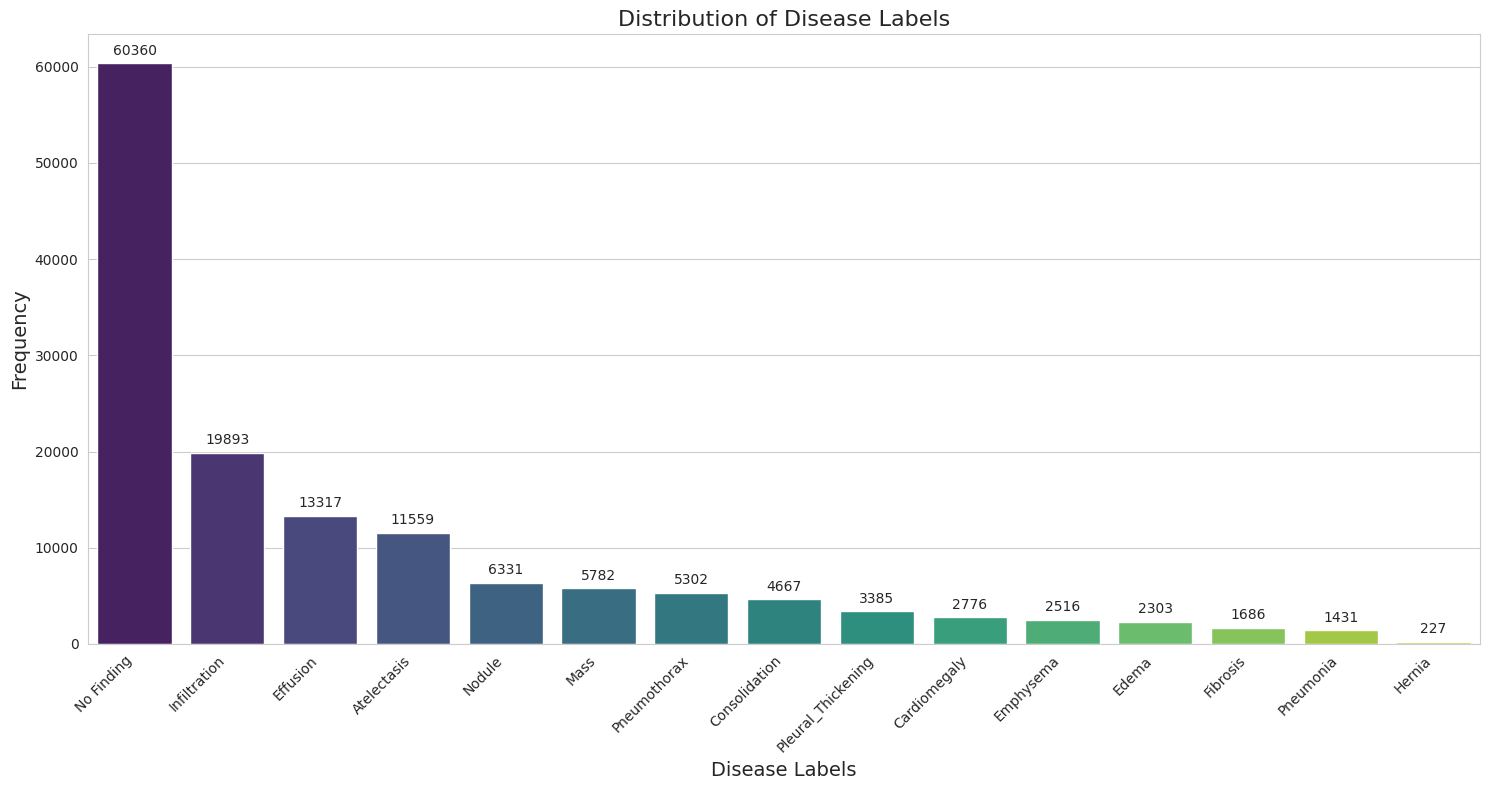

In [ ]:
label_counts = Counter()
for labels in df['Finding Labels']:
    label_counts.update(labels.split('|'))

label_counts_series = pd.Series(label_counts).sort_values(ascending=False)

# --- Plotting the Visualization ---

sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=label_counts_series.index, y=label_counts_series.values, palette='viridis', hue=label_counts_series.index, legend=False)
plt.title('Distribution of Disease Labels', fontsize=16)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Disease Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Replace 'No Finding' with an empty string
df['Finding Labels'] = df['Finding Labels'].str.replace('No Finding', '')

# Get unique labels and create one-hot encoded columns
all_labels = (df['Finding Labels'].str.split('|', expand=True)
              .stack()
              .str.strip()
              .unique())
all_labels = [x for x in all_labels if len(x) > 0] # Remove empty strings

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create one-hot encoded columns for each label
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].str.contains(c_label).astype(float)

All Labels (14): ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [ ]:
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
54511,00013670_018.png,,18,13670,56,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16562,00004435_003.png,,3,4435,28,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73946,00018187_007.png,,7,18187,32,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [ ]:
# Create a single labels column with all 14 binary values
df.loc[:, 'labels_vec'] = df.apply(lambda row: [row[p] for p in all_labels], axis=1)

In [ ]:
print("Labels have been multi-hot encoded.")
df[['Image Index', 'Finding Labels', 'labels_vec'] + all_labels].head()

Labels have been multi-hot encoded.


,Image Index,Finding Labels,labels_vec,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title Multi-Label Stratified Data Splitting
print("\nSplitting data into training, validation, and test sets...")

df_to_split = df.copy()
if USE_SUBSET:
    # To make stratification effective, we sample patients first, then stratify their images
    unique_patients = df_to_split['Patient ID'].unique()
    subset_patient_ids = np.random.choice(unique_patients,
                                          size=int(len(unique_patients) * SUBSET_FRACTION),
                                          replace=False)
    df_to_split = df_to_split[df_to_split['Patient ID'].isin(subset_patient_ids)]
    print(f"Using a subset of {len(df_to_split)} images for splitting.")


Splitting data into training, validation, and test sets...
Using a subset of 56491 images for splitting.


In [ ]:
# Prepare data for the stratifier (X=features, y=labels)
X = df_to_split['full_path'].values.reshape(-1, 1)
y = np.array(df_to_split['labels_vec'].tolist())

# Split into Train (70%) and a temporary set (30%)
stratifier_traintest = IterativeStratification(n_splits=10, order=1)
train_indices, temp_indices = next(stratifier_traintest.split(X, y))

train_df = df_to_split.iloc[train_indices]
temp_df = df_to_split.iloc[temp_indices]

# Split the temporary set (30%) into Validation (10%) and Test (20%)
X_temp = temp_df['full_path'].values.reshape(-1, 1)
y_temp = np.array(temp_df['labels_vec'].tolist())

stratifier_valtest = IterativeStratification(n_splits=3, order=1) # 1/3 of temp_df for validation
val_indices, test_indices = next(stratifier_valtest.split(X_temp, y_temp))

val_df = temp_df.iloc[val_indices]
test_df = temp_df.iloc[test_indices]

print("\nData split successfully:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")



Data split successfully:
Train samples: 50841
Validation samples: 3766
Test samples: 1884


In [ ]:
# Create final arrays for the data pipelines
X_train, y_train = train_df['full_path'].values, np.array(train_df['labels_vec'].tolist())
X_val, y_val = val_df['full_path'].values, np.array(val_df['labels_vec'].tolist())
X_test, y_test = test_df['full_path'].values, np.array(test_df['labels_vec'].tolist())

In [ ]:
#@title Create TensorFlow Data Pipeline
# --- Image Augmentation Layers ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomBrightness(factor=0.1),
], name="data_augmentation")

def parse_image(filepath, label):
    """Loads an image file and preprocesses it for the DenseNet model."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    # Normalize using ImageNet stats
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

def create_dataset(filepaths, labels, augment=False):
    """Creates a batched, prefetched, and optionally augmented tf.data.Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                               num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the final datasets for training, validation, and testing
train_ds = create_dataset(X_train, y_train, augment=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

print("Data pipelines created successfully.")

Data pipelines created successfully.


In [ ]:
# Check the output shape

# sample = train_ds.take(1)
# for images, labels in sample:
#     print("Images batch shape:", images.shape)
#     print("Labels batch shape:", labels.shape)

# **Obj 1: Model Comparison**

Model Buiding, Training and Evaluation

In [ ]:
#@title Define the Callbacks

# 1. Robust Metrics Callback to calculate macro-averaged AUC
# class MetricsCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_dataset):
#         super().__init__()
#         self.validation_dataset = validation_dataset
#         self.y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         y_pred = self.model.predict(self.validation_dataset, verbose=0)
#         class_aucs = []
#         # Calculate AUC for each class individually to handle single-class cases
#         for i in range(self.y_true.shape[1]):
#             try:
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore")
#                     class_auc = roc_auc_score(self.y_true[:, i], y_pred[:, i])
#                     class_aucs.append(class_auc)
#             except ValueError:
#                 pass # Ignore classes with no positive samples in the batch

#         if class_aucs:
#             logs['val_roc_auc'] = np.mean(class_aucs)
#             print(f" - val_roc_auc: {logs['val_roc_auc']:.4f}", end="")

# 2. Callback to save the best model weights based on validation AUC
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODELS_DIR, "densenet121_best.weights.h5"),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# 3. Callback to stop training early if there's no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5, # Stop after 5 epochs of no improvement
    verbose=1,
    restore_best_weights=True
)

# metrics_callback = MetricsCallback(validation_dataset=val_ds)
print("Callbacks are ready.")

Callbacks are ready.


In [ ]:
#@title Focal Loss Fuction

# Focal Loss implementation
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss function for multi-label classification.
    alpha: Balances positive/negative examples.
    gamma: Modulates the easy/hard examples.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

    # Calculate cross-entropy
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

    # Calculate modulating factor for positive and negative samples
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    modulating_factor = tf.pow(1.0 - p_t, gamma)

    # Calculate alpha factor
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    focal_loss = alpha_factor * modulating_factor * bce
    return K.mean(focal_loss)

In [ ]:
#@title Advanced CNN - DenseNet-121-base
def build_densenet_model(input_shape, num_classes, dropout_rate=0.4):
    """Defines the model architecture using a pre-trained DenseNet-121 base."""
    # Load pre-trained DenseNet-121 on ImageNet, without its classification layer
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model so we only train the new head initially
    base_model.trainable = False

    # Add a custom classification head for our 14 classes
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False) # Set training=False to keep batch norm layers in inference mode
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x, training=True)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x, training=True)
    outputs = Dense(num_classes, activation='sigmoid', name='predictions')(x) # Sigmoid for multi-label

    model = Model(inputs=inputs, outputs=outputs, name="DenseNet121")
    return model, base_model

# Build the model
densenet_with_mc_model, base_model = build_densenet_model(input_shape=(*IMG_SIZE, 3), num_classes=len(all_labels))

# Display model summary
print("-------------Custom Layer Summary: ------------------")
densenet_with_mc_model.summary()
# print("-------------Base Model Summary: ------------------")
# base_model.summary()

-------------Custom Layer Summary: ------------------


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,569,486 (28.88 MB)

 Trainable params: 531,982 (2.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
print("-------------Base Model Summary: ------------------")
base_model.summary()

-------------Base Model Summary: ------------------


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ cast_2[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# --- Stage 1: Train the Classifier Head ---
print("\n--- STAGE 1: TRAINING CLASSIFIER HEAD ---")
densenet_with_mc_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss=focal_loss,
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True)]
)
model_name = "DenseNet-121-with-MC"
history_stage1 = densenet_with_mc_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]
)


--- STAGE 1: TRAINING CLASSIFIER HEAD ---
Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5344 - loss: 0.0228
Epoch 1: val_auc improved from -inf to 0.61667, saving model to /content/drive/MyDrive/Chest XRay/models/densenet121_best.weights.h5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1896s 1s/step - auc: 0.5344 - loss: 0.0228 - val_auc: 0.6167 - val_loss: 0.0180
Epoch 2/10
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - auc: 0.5423 - loss: 0.0180
Epoch 2: val_auc improved from 0.61667 to 0.63264, saving model to /content/drive/MyDrive/Chest XRay/models/densenet121_best.weights.h5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 232s 147ms/step - auc: 0.5423 - loss: 0.0180 - val_auc: 0.6326 - val_loss: 0.0179
Epoch 3/10
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - auc: 0.5423 - loss: 0.0178
Epoch 3: val_auc improved from 0.63264 to 0.65591, saving model to /content/drive/MyDrive/Chest XRay/models/densenet121_best.weights.h5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 233s 148ms/step - auc: 0.5423 - loss: 0.0178 

In [ ]:
# Convert the history object to a Pandas DataFrame
history_stage1_df = pd.DataFrame(history_stage1.history)
history_stage1_df['epoch'] = history_stage1_df.index + 1
history_stage1_df['model'] = model_name

# Append to the CSV file, creating it if it doesn't exist
# Set header=False if the file already exists to avoid writing multiple headers
history_stage1_df.to_csv(HISTORY_CSV_PATH, mode='a', header=not os.path.exists(HISTORY_CSV_PATH), index=False)

print(f"Saved training history for {model_name} to {HISTORY_CSV_PATH}")

Saved training history for DenseNet-121-with-MC to /content/drive/MyDrive/Chest XRay/training_history.csv


In [ ]:
# --- Stage 2: Fine-Tuning the Full Model ---
print("\n--- STAGE 2: FINE-TUNING FULL MODEL ---")
# Unfreeze the base model to allow its weights to be updated
base_model.trainable = True

# Re-compile with a very low learning rate for fine-tuning
densenet_with_mc_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
    loss=focal_loss,
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True)]
)

history_stage2 = densenet_with_mc_model.fit(
    train_ds,
    epochs=25, # Continue training for more epochs
    validation_data=val_ds,
    initial_epoch=len(history_stage1.epoch),
    callbacks=[model_checkpoint, early_stopping]
)
print("\nTraining complete.")


--- STAGE 2: FINE-TUNING FULL MODEL ---
Epoch 11/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - auc: 0.5142 - loss: 0.0183
Epoch 11: val_auc did not improve from 0.66222
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 563s 229ms/step - auc: 0.5142 - loss: 0.0183 - val_auc: 0.6398 - val_loss: 0.0174
Epoch 12/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - auc: 0.5325 - loss: 0.0177
Epoch 12: val_auc did not improve from 0.66222
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 244s 155ms/step - auc: 0.5325 - loss: 0.0177 - val_auc: 0.6609 - val_loss: 0.0172
Epoch 13/25
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - auc: 0.5422 - loss: 0.0175
Epoch 13: val_auc improved from 0.66222 to 0.66366, saving model to /content/drive/MyDrive/Chest XRay/models/densenet121_best.weights.h5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 247s 157ms/step - auc: 0.5422 - loss: 0.0175 - val_auc: 0.6637 - val_loss: 0.0170
Epoch 14/25
1574/1575 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - auc: 0.5492 - loss: 0.0174
Epoch 14: val_auc improved from 0.66366 to 0.

In [ ]:
# Convert the history object to a Pandas DataFrame
history_stage2_df = pd.DataFrame(history_stage2.history)
history_stage2_df['epoch'] = len(history_stage1_df) + history_stage2_df.index + 1
history_stage2_df['model'] = model_name

# Append to the CSV file, creating it if it doesn't exist
# Set header=False if the file already exists to avoid writing multiple headers
history_stage2_df.to_csv(HISTORY_CSV_PATH, mode='a', header=not os.path.exists(HISTORY_CSV_PATH), index=False)

print(f"Saved training history for {model_name} to {HISTORY_CSV_PATH}")

Saved training history for DenseNet-121-with-MC to /content/drive/MyDrive/Chest XRay/training_history.csv


In [ ]:
#@title Final Evaluation on the Test Set
print("\n--- FINAL EVALUATION ON TEST SET ---")

# Load the best weights saved by the ModelCheckpoint callback
print("Loading best model weights from training...")
densenet_with_mc_model.load_weights(os.path.join(MODELS_DIR, "densenet121_best.weights.h5"))

# Evaluate the model on the unseen test data
results = densenet_with_mc_model.evaluate(test_ds, return_dict=True, verbose=0)
print(f"\nTest Loss: {results['loss']:.4f}")
print(f"Test AUC (Keras built-in): {results['auc']:.4f}")

# Calculate the precise, macro-averaged AUC on the entire test set
print("\nCalculating precise AUC using scikit-learn...")
test_true = np.concatenate([y for x, y in test_ds], axis=0)
test_pred = densenet_with_mc_model.predict(test_ds)
final_auc = roc_auc_score(test_true, test_pred, average='macro')
print(f"Test AUC (scikit-learn, macro-average): {final_auc:.4f}")

# Print class-wise AUC scores to see performance on each pathology
print("\n--- Class-wise Test AUC ---")
class_auc_scores = roc_auc_score(test_true, test_pred, average=None)
for i, pathology in enumerate(all_labels):
    print(f"{pathology:>20}: {class_auc_scores[i]:.4f}")


--- FINAL EVALUATION ON TEST SET ---
Loading best model weights from training...

Test Loss: 0.0165
Test AUC (Keras built-in): 0.7102

Calculating precise AUC using scikit-learn...
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step
Test AUC (scikit-learn, macro-average): 0.7096

--- Class-wise Test AUC ---
        Cardiomegaly: 0.6205
           Emphysema: 0.7737
            Effusion: 0.8519
              Hernia: 0.6762
        Infiltration: 0.6168
                Mass: 0.6781
              Nodule: 0.6428
         Atelectasis: 0.7103
        Pneumothorax: 0.7911
  Pleural_Thickening: 0.7081
           Pneumonia: 0.7308
            Fibrosis: 0.6980
               Edema: 0.7482
       Consolidation: 0.6880


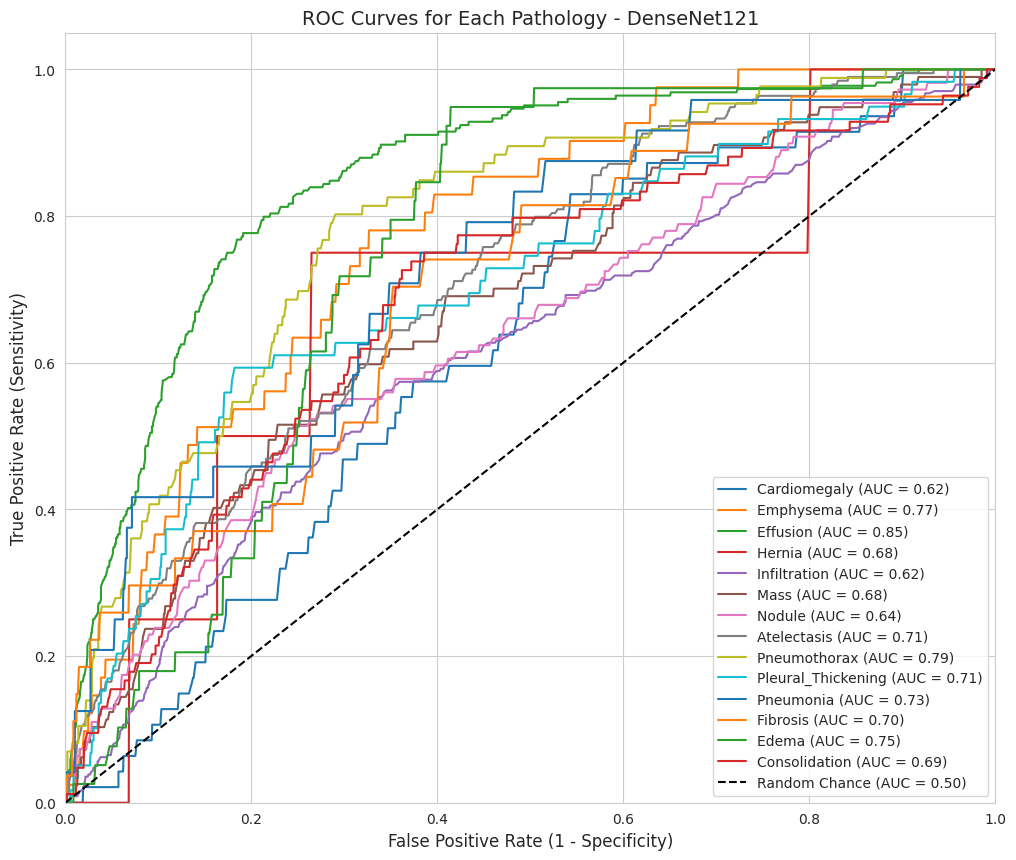

In [ ]:
#@title Plot ROC-AUC Curves for Each Class

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set up the plot
plt.figure(figsize=(12, 10))

for i, pathology in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_true[:, i], test_pred[:, i])
    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{pathology} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves for Each Pathology - DenseNet121', fontsize=14)

plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()